In [2]:
import alborex_functions
import alborexdata
import netCDF4
import glob
import os
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap 
import numpy as np
import datetime
from importlib import reload

In [3]:
reload(alborexdata)

<module 'alborexdata' from '/home/ctroupin/Publis/201703_AlborexData/python/alborexdata.py'>

In [4]:
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

# Configuration

Create a logger

In [5]:
logger = alborexdata.configure_logging("./logs/alborexFigure5.log")

Domain

In [6]:
coordinates = [-6.75, 3.001, 34.75, 40.]
coordinates2 = [-1, -0.25, 36.65, 37.25]

Create a list of netCDF files containing SST

In [7]:
figdir = "../figures/CTD/"
sstdir = "/home/ctroupin/Data/Alborex/SST/"
datadir = "/home/ctroupin/Data/Alborex/CTD/"

In [8]:
coastfile = "../data/coastline_cartex_f3.txt"
rvfile = os.path.join(datadir, "../RV/dep0015_socib-rv_scb-pos001_L1_2014-05-25.nc")
datafilelist = sorted(glob.glob(os.path.join(datadir, '*L1*.nc')))
nfiles = len(datafilelist)
if nfiles == 0:
    logger.warning("No data files in directory {0}".format(datadir))
else:
    logger.info("Working on {0} data files".format(nfiles))

2018-01-09 20:32:37,823 - alborex_logger - INFO - Working on 1 data files


# Data reading and plotting

Make figure directory if necessary.

In [9]:
if os.path.isdir(figdir):
    logger.debug("Figure directory {0} already exists".format(figdir))
else:
    os.makedirs(figdir)
    logger.debug("Creating figure directory {0}".format(figdir))

2018-01-09 20:32:38,664 - alborex_logger - DEBUG - Figure directory ../figures/CTD/ already exists


## Coastline

In [10]:
coastdir = '../data/'
coastfile = os.path.join(coastdir, 'coastline_cartex_f3.txt')

if os.path.exists(coastfile):
    logger.info("{0} exists".format(coastfile))
    loncoast, latcoast = alborexdata.read_lonlat_coast(coastfile)
else:
    logger.warning("{0} does't exist".format(coastfile))  

2018-01-09 20:32:39,654 - alborex_logger - INFO - ../data/coastline_cartex_f3.txt exists


## Ship track

In [11]:
ship = alborexdata.Ship()
ship.get_from_netcdf(rvfile)
ship.apply_qc_latlon(QC=[1, 2])

## SST

In [12]:
sstfile = os.path.join(sstdir, "A2014150020500.L2_LAC_SST4.nc")
lonsst, latsst, sst, sstqual, year, day, platform = alborex_functions.load_sst_l2(sstfile)
# Make the SST when flag > 1
sst = np.ma.masked_where(sstqual > 1, sst)

Create the projection (only once)

In [13]:
m = Basemap(projection='merc', llcrnrlon=coordinates2[0], llcrnrlat=coordinates2[2],
            urcrnrlon=coordinates2[1], urcrnrlat=coordinates2[3],
            lat_ts=0.5 * (coordinates2[2] + coordinates2[3]), resolution='h')

## Plot CTD positions

2018-01-09 20:33:38,466 - alborex_logger - INFO - Making figure ctd_casts
/home/ctroupin/Software/PythonEnvs/Diva-python3.6/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:4771: RuntimeWarning: invalid value encountered in greater
  lonsin = np.where(lonsin > lon_0+180, lonsin-360 ,lonsin)
/home/ctroupin/Software/PythonEnvs/Diva-python3.6/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:4772: RuntimeWarning: invalid value encountered in less
  lonsin = np.where(lonsin < lon_0-180, lonsin+360 ,lonsin)
/home/ctroupin/Software/PythonEnvs/Diva-python3.6/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:4776: RuntimeWarning: invalid value encountered in greater_equal
  itemindex = len(lonsin)-np.where(londiff>=thresh)[0]


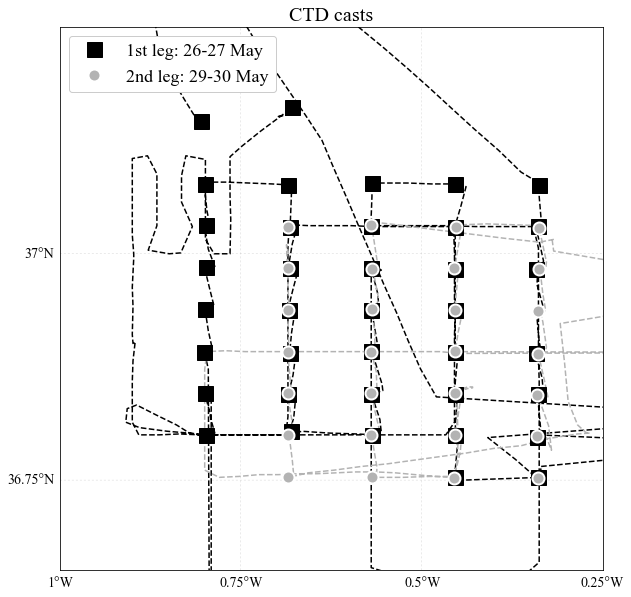

In [17]:
figname = "ctd_casts"
fignamesst = "ctd_casts_sst"
figtitle = "CTD casts"
logger.info("Making figure {0}".format(figname))

fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(111)
m.ax = ax

# Add the coastline
for i in range(0, len(loncoast)):
    m.plot(np.array(loncoast[i]), np.array(latcoast[i]), 
           color='k', linewidth=.5, latlon=True)

alborexdata.add_map_grid(m, coordinates, dlon=.25, dlat=.25,
                         fontname='Times New Roman', fontsize=14, 
                         linewidth=0.2, zorder=1, color=".6")
    

datafile = datafilelist[0]

# logger.debug("Working on file: {0}".format(os.path.basename(datafiles)))

# Read data from file
ctd = alborexdata.CTD()
ctd.get_from_netcdf(datafilelist[0])

# Add to plot
m.plot(ctd.lon[:38], ctd.lat[:38], 's', ms=15, color="k",
       latlon=True, label="1st leg: 26-27 May", zorder=4)
m.plot(ctd.lon[38:], ctd.lat[38:], 'o', color=".7", ms=12, 
       markeredgecolor="w", markeredgewidth=2,
       latlon=True, label="2nd leg: 29-30 May", zorder=5)

# Add ship track
ship.lon.mask = False
ship.lat.mask = False
ship.select_dates(finaldate=ctd.dates[38])
ship.plot_track(m, color="k", zorder=3)

# Reset mask
ship.lon.mask = False
ship.lat.mask = False
ship.select_dates(finaldate=ctd.dates[-1], initialdate=ctd.dates[39])
ship.plot_track(m, color=".7", zorder=3)

plt.legend(loc=2, fontsize=18, framealpha=1)

plt.title(figtitle, fontsize=20)

# plt.savefig(os.path.join(figdir, figname), dpi=300, bbox_inches='tight')
plt.show()

# Add SST as background
pcm = m.pcolormesh(lonsst, latsst, sst, latlon=True, 
               vmin=18, vmax=20.5, cmap=plt.cm.gray_r,
               alpha=.85)

# plt.savefig(os.path.join(figdir, fignamesst), dpi=300, bbox_inches='tight')
plt.close()

# Ship track

/home/ctroupin/Software/PythonEnvs/Diva-python3.6/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:4771: RuntimeWarning: invalid value encountered in greater
  lonsin = np.where(lonsin > lon_0+180, lonsin-360 ,lonsin)
/home/ctroupin/Software/PythonEnvs/Diva-python3.6/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:4772: RuntimeWarning: invalid value encountered in less
  lonsin = np.where(lonsin < lon_0-180, lonsin+360 ,lonsin)
/home/ctroupin/Software/PythonEnvs/Diva-python3.6/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:4776: RuntimeWarning: invalid value encountered in greater_equal
  itemindex = len(lonsin)-np.where(londiff>=thresh)[0]


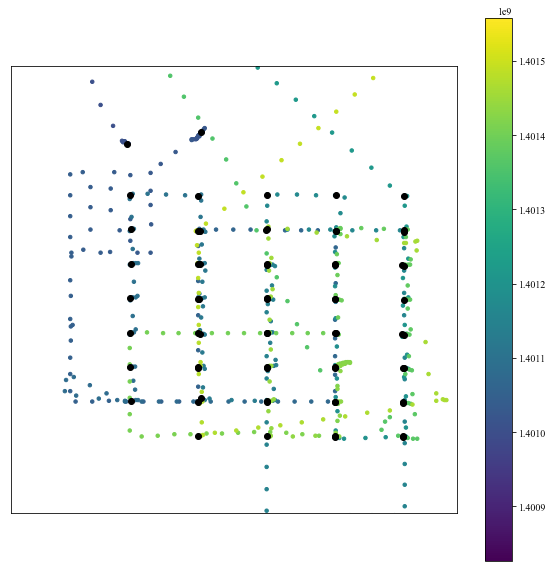

In [15]:
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(111)
m.ax = ax
ship.lon.mask = False
ship.lat.mask = False
ship.apply_qc_latlon()
scat = m.scatter(ship.lon, ship.lat, s=12, c=ship.time, latlon=True)
m.plot(ctd.lon, ctd.lat, 'ko', latlon=True)
plt.colorbar(scat)
plt.show()
plt.close()

In [15]:
def plot_mid_arrow(x, y, arrowwidth=1, headwidth=.7, arrowcolor='k'):
    """
    Plot an arrow joining each pair of points specified by
    x and y (iterable) with the arrow head located halfway 
    """
    
    # Specify arrow styles 
    arrowstyle1 = dict(width=arrowwidth, headwidth=headwidth, color=arrowcolor)
    arrowstyle2 = dict(width=arrowwidth, headwidth=0, color=arrowcolor)
    
    # Iterate on points
    if len(x) == len(y):
        for ii in range(0, len(x)-1):
            plt.annotate("",
                    xytext=(x[ii], y[ii]), 
                    xy=(.5 * (x[ii] + y[ii+1]), 5 * (y[ii] + y[ii+1])),
                    textcoords="data", xycoords="data",
                    arrowprops=arrowstyle1)
            plt.annotate("",
                    xy=(x[ii+1], y[ii+1]), 
                    xytext=(.5 * (x[ii] + x[ii+1]), .5 * (y[ii] + y[ii+1])),
                    arrowprops=arrowstyle2)
    else:
        print("x and y should have the same length")

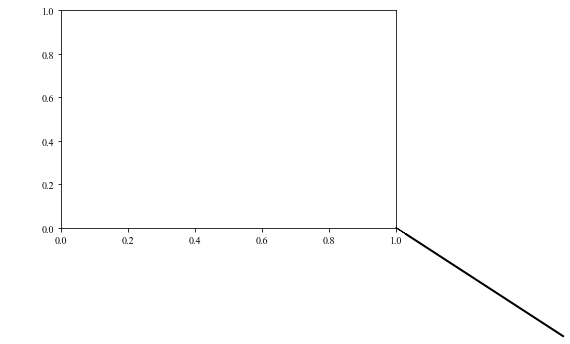

In [16]:
fig = plt.figure()
plot_mid_arrow([0, 1, 2, 1], [2, 3, -1, 0])
plt.show()
plt.close()

In [10]:
plt.annotate?

In [20]:
xx, yy = m(ctd.lon, ctd.lat)

In [22]:
xx

array([ 17345.96760104,  28462.67122241,  17905.80159636,  17790.28029574,
        17745.84902627,  17790.28029574,  17905.80159636,  17888.02908858,
        17754.73528017,  28009.47227382,  28231.62862116,  28240.51487506,
        28124.99357444,  28284.94614453,  28036.1310355 ,  28409.35369904,
        38273.09552136,  38237.55050578,  38193.11923631,  38210.8917441 ,
        38210.8917441 ,  38184.23298242,  38317.52679083,  48536.7187689 ,
        48536.7187689 ,  48447.85622996,  48456.74248386,  48518.94626111,
        48474.51499164,  48474.51499164,  48456.74248386,  58631.50319246,
        58587.07192299,  58711.47947751,  58471.55062237,  58471.55062237,
        58649.27570025,  58764.79700087,  58631.50319246,  58578.1856691 ,
        58604.84443078,  58675.93446193,  58649.27570025,  58782.56950866,
        58755.91074698,  48581.15003837,  48412.31121439,  48447.85622996,
        48447.85622996,  48456.74248386,  48447.85622996,  48430.08372217,
        38255.32301357,  

In [28]:
arrowwidth = 1
headwidth=7
arrowcolor="y"
# Specify arrow styles 
arrowstyle1 = dict(width=arrowwidth, headwidth=headwidth, color=arrowcolor)
arrowstyle2 = dict(width=arrowwidth, headwidth=0, color=arrowcolor)

In [ ]:
plt.figure
ax = plt.subplot(111)
m.ax = ax
 
# Iterate on points
for ii in range(0, 1):
    print(xx[ii], yy[ii])
    print(.5 * (xx[ii] + yy[ii+1]), 5 * (yy[ii] + yy[ii+1]))
    plt.annotate("",
            xytext=(xx[ii], yy[ii]), 
            xy=(.5 * (xx[ii] + yy[ii+1]), 5 * (yy[ii] + yy[ii+1])),
            textcoords="data", xycoords="data",
            arrowprops=arrowstyle1)
    """
    plt.annotate("",
            xy=(x[ii+1], y[ii+1]), 
            xytext=(.5 * (x[ii] + x[ii+1]), .5 * (y[ii] + y[ii+1])),
            arrowprops=arrowstyle2)
    """
plt.show()
plt.close()

In [1]:
m

NameError: name 'm' is not defined

In [25]:
plt